# ELR Data Profiling Template

This notebook is a template for how we might use some basic python data analysis (i.e. pandas) to profile incoming ELR data. The code is likely adaptable to ECR data as well, if it fits into a pipe-delimited HL7 v2.XX format. This notebook will attempt to answer extremely basic questions involving the cleanliness and formatting of the data, such as proportion of missing fields per field, proportion of missing required fields, proportion of records with demographic info, etc.

In [1]:
'''
Note on use: the HL7.Container object parsed by the hl7 package
is a subclass of python list, which gives us easy access for indices:
  Message
  Segment
  Field
  Repetition
  Component
'''
import hl7
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Location of file to open
import os

HOME_DIR = os.path.expanduser('~')
DATA_DIR = os.path.join(HOME_DIR, 'inventory', 'SampleData', 'PRE') # THIS IS THE ONLY HARD CODE PATH YOU NEED TO CHANGE
IN_FILE = os.path.join(DATA_DIR, 'PreTranslation_to_State_VA.hl7')

In [3]:
'''
May need to write a different type of file parser depending on format
of real file. The python HL7 library doesn't read from files, just individual
messages, so we have to concatenate them in a meaningful format. Parsing
via string concatenation is suggested in their docs, since newlines and 
carriage returns delimit segments and blank lines delimit messages themselves.
'''
msgs = []
with open(IN_FILE, 'r') as fp:
    msg = ''
    for line in fp:
        if line.strip() == '':
            msgs.append(msg)
            msg = ''
        else:
            strp_line = line.strip()
            msg += '\r' + strp_line

# Verify correctness of data loading: I count ten messages in this 
# representative set; all messages MUST begin with the message
# header signifier 'MSH'
expected_msgs = 10
assert len(msgs) == expected_msgs
starts_with_msg_header = [x.split('|')[0].strip() == 'MSH' for x in msgs]
assert all(starts_with_msg_header)
hl7_msgs = [hl7.parse(x) for x in msgs]

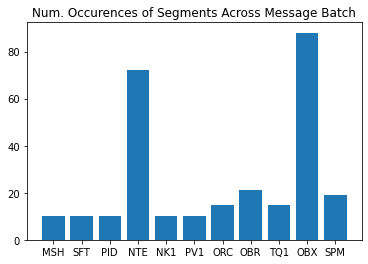

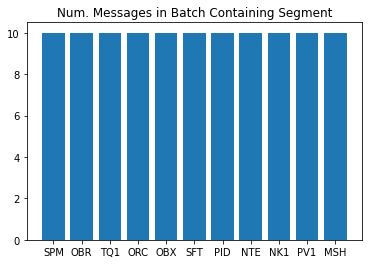

In [4]:
'''
Receives a list of parsed hl7 messages, determine the unique segments
contained in each message, and generate a profiling histogram showing
the frequencies of each present segment across each present message.
'''
def profile_segments_in_hl7_batch(messages: list):
    total_counts = {}
    message_counts = {}
    
    for m in messages:
        segments = list([str(x[0]) for x in m])
        
        # Total number of times this segment occurs in batch
        for s in segments:
            if s not in total_counts:
                total_counts[s] = 0
            total_counts[s] += 1
            
        # Number of messages containing one or more of segment
        seg_set = set(segments)
        for s in seg_set:
            if s not in message_counts:
                message_counts[s] = 0
            message_counts[s] += 1
    
    labels = list(total_counts.keys())
    heights = list(total_counts.values())
    plt.bar(labels, heights)
    plt.title('Num. Occurences of Segments Across Message Batch')
    plt.show()
    
    labels = list(message_counts.keys())
    heights = list(message_counts.values())
    plt.bar(labels, heights)
    plt.title('Num. Messages in Batch Containing Segment')
    plt.show()
    
profile_segments_in_hl7_batch(hl7_msgs)

In [5]:
# From docs: "Note that since the first element of the segment is the 
# segment name, segments are effectively 1-based in python as well 
PID_REQUIRED_FIELDS = [3,5]

'''
Profile the occurence of a single segment (given by segment identifier
sid) in a single message. This identifies whether the segment is present,
how many fields are present in the segment, and how many of those fields
contain information. If an array is provided giving the "optional" or
"required" status of each field in the segment, then the function also
reports how many required fields are missing and how many optional fields
are filled.
'''
def profile_segment_in_message(sid: str, message: hl7, field_reqs=None):
    segment = []
    try:
        segment = message.segments(sid)
    except:
        return None
    
    profile = {
        'segment': sid,
        'fields present': len([x for x in segment[0] if str(x).strip() != ''])
    }
    if field_reqs != None:
        profile['requirements missing'] = len([x for x in field_reqs if str(segment[0][x]).strip() == ''])
        profile['optionals present'] = len([i for i in range(len(segment[0])) if i not in field_reqs and str(segment[0][i]).strip() != ''])
      
    return profile
    

profile = profile_segment_in_message('PID', hl7_msgs[0], field_reqs=PID_REQUIRED_FIELDS)
print(profile)

{'segment': 'PID', 'fields present': 17, 'requirements missing': 0, 'optionals present': 15}


In [6]:
'''
Basic function to extract an address from an HL7 message using the field
schema here https://hl7-definition.caristix.com/v2/HL7v2.4/Fields/PID.11.
The function only extracts fields that are necessary for geocoding, rather
than all included geographic information in the message. Fields are parsed
as strings and returned in a dictionary object with keys corresponding to
address fields (street, city, state, zip_postal).
'''
def extract_address(msg: hl7):
    components = msg.segment('PID')(11)(0)
    street = str(components(1)).strip()
    city = str(components(3)).strip()
    state = str(components(4)).strip()
    zip_postal = str(components(5)).strip()
    return {
        'street': street,
        'city': city,
        'state': state,
        'zip_postal': zip_postal
    }

print(extract_address(hl7_msgs[0]))

{'street': '7455 WASHINGTON AVE', 'city': 'LAKEWOOD', 'state': 'CO', 'zip_postal': '22408'}


In [8]:
addresses = [extract_address(hl7) for hl7 in hl7_msgs]

In [10]:
addresses_df = pd.DataFrame(addresses)

In [11]:
addresses_df.head()

,street,city,state,zip_postal
0,7455 WASHINGTON AVE,LAKEWOOD,CO,22408
1,7762 UPTON STREET,BANK AMERICARD,CO,23015
2,7762 UPTON STREET,BANK AMERICARD,CO,23015
3,1835 79TH ST,DOUGLAS GARDENS,OR,23116
4,4174 ORANGE BLOSSOMCR,HUNTINGTON BEACH,CA,23237
